In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz


RESULTS_FOLDER = 'smile_osa_results'

Found 18 patient result files. Processing...


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_56829/3150653192.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(



Plot successfully saved to 'patient_event_totals_by_id.png'


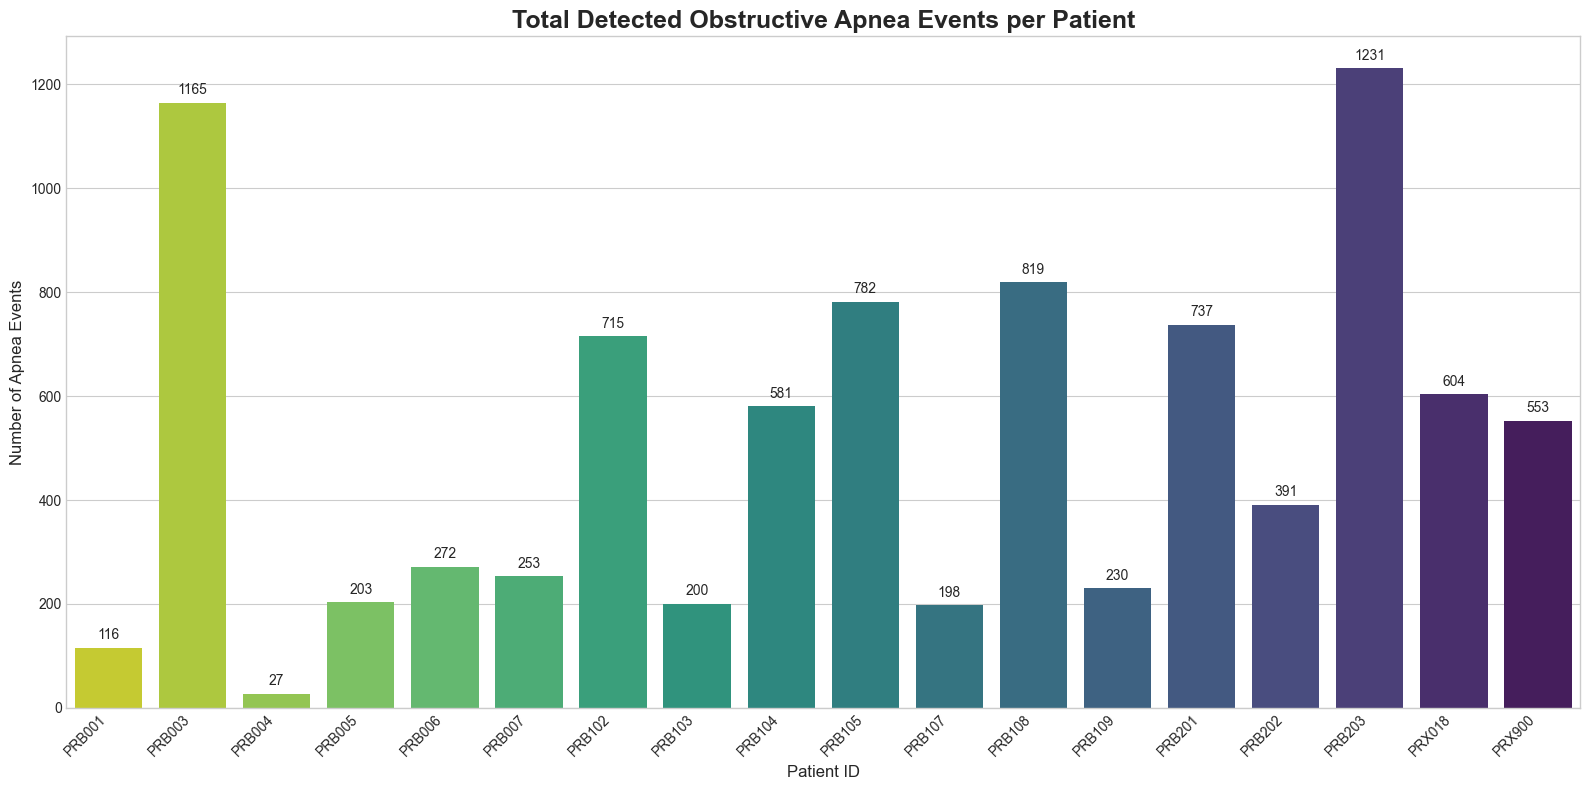

In [3]:

def plot_total_events_per_patient(results_folder, output_filename="patient_event_totals_by_id.png"):
    """
    Finds all patient OSA result CSVs in a folder, counts the events for each,
    and generates a bar plot summarizing the totals, ordered by Patient ID.

    Args:
        results_folder (str): The path to the folder containing the _osa.csv files.
        output_filename (str): The filename for the saved plot image.
    """
    # --- 1. Find and process all result files ---
    search_pattern = os.path.join(results_folder, "*_osa.csv")
    result_files = glob.glob(search_pattern)

    if not result_files:
        print(f"Error: No '*_osa.csv' files found in the folder: '{results_folder}'")
        return

    print(f"Found {len(result_files)} patient result files. Processing...")

    patient_events = {}
    for file_path in result_files:
        filename = os.path.basename(file_path)
        patient_id = filename.split('_osa.csv')[0]

        try:
            df = pd.read_csv(file_path)
            event_count = len(df)
            patient_events[patient_id] = event_count
        except pd.errors.EmptyDataError:
            patient_events[patient_id] = 0
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")

    # --- 2. Prepare data for plotting ---
    if not patient_events:
        print("No valid patient data to plot.")
        return

    events_df = pd.DataFrame(list(patient_events.items()), columns=['PatientID', 'EventCount'])

    # <<< FIX: Sort the DataFrame by PatientID instead of EventCount
    events_df_sorted = events_df.sort_values('PatientID', ascending=True)

    # --- 3. Create and customize the plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 8))

    ax = sns.barplot(
        x='PatientID',
        y='EventCount',
        data=events_df_sorted,
        palette='viridis_r' # Reversed palette for variety
    )

    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), '.0f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center',
            va = 'center',
            xytext = (0, 9),
            textcoords = 'offset points'
        )

    plt.title('Total Detected Obstructive Apnea Events per Patient', fontsize=18, fontweight='bold')
    plt.xlabel('Patient ID', fontsize=12)
    plt.ylabel('Number of Apnea Events', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # --- 4. Save and show the plot ---
    # I've updated the output filename to reflect the new sorting
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot successfully saved to '{output_filename}'")
    
    plt.show()



plot_total_events_per_patient(results_folder=RESULTS_FOLDER)

Found 18 patient result files. Processing and normalizing...


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_56829/158234026.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(



Plot successfully saved to 'patient_normalized_events.png'


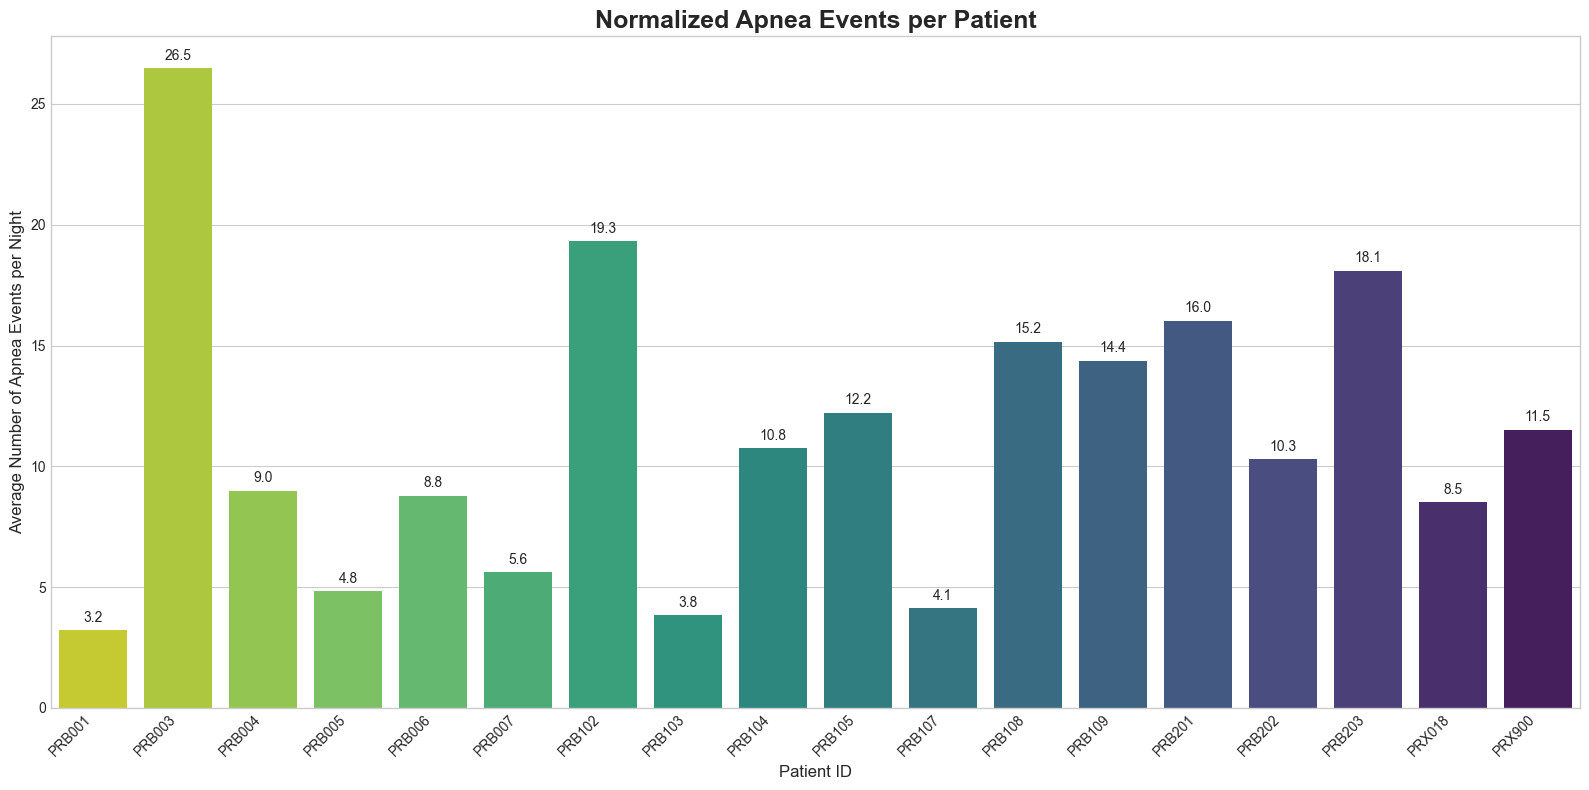

In [13]:
# plot_normalized_events.py

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_normalized_events_per_patient(results_folder, output_filename="patient_normalized_events.png"):
    """
    Finds all patient OSA result CSVs, calculates the average number of events
    per night for each, and generates a bar plot of this normalized metric.
    """
    search_pattern = os.path.join(results_folder, "*_osa.csv")
    result_files = glob.glob(search_pattern)

    if not result_files:
        print(f"Error: No '*_osa.csv' files found in the folder: '{results_folder}'")
        return

    print(f"Found {len(result_files)} patient result files. Processing and normalizing...")

    patient_normalized_events = {}
    for file_path in result_files:
        filename = os.path.basename(file_path)
        patient_id = filename.split('_osa.csv')[0]

        try:
            df = pd.read_csv(file_path)
            if df.empty:
                # If the file is empty, the patient has 0 events and 0 nights with events.
                patient_normalized_events[patient_id] = 0
                continue

            # Count the total number of events
            total_event_count = len(df)
            
            # Count the number of unique nights
            # This assumes the 'date' column exists and is accurate
            if 'date' in df.columns:
                num_unique_nights = df['date'].nunique()
            else:
                print(f"Warning: 'date' column not found in {filename}. Cannot normalize. Skipping patient {patient_id}.")
                continue

            # Calculate the average events per night. Avoid division by zero.
            if num_unique_nights > 0:
                avg_events_per_night = total_event_count / num_unique_nights
            else:
                avg_events_per_night = 0
            
            patient_normalized_events[patient_id] = avg_events_per_night

        except Exception as e:
            print(f"Could not process file {file_path}: {e}")

    # --- Prepare data for plotting ---
    if not patient_normalized_events:
        print("No valid patient data to plot.")
        return

    # Create a DataFrame from the normalized results
    events_df = pd.DataFrame(list(patient_normalized_events.items()), columns=['PatientID', 'AvgEventsPerNight'])
    
    # Sort by PatientID for consistent ordering
    events_df_sorted = events_df.sort_values('PatientID', ascending=True)

    # --- Create and customize the plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 8))

    ax = sns.barplot(
        x='PatientID',
        y='AvgEventsPerNight',
        data=events_df_sorted,
        palette='viridis_r'
    )

    # Add the exact average value on top of each bar
    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), '.1f'), # Format to one decimal place
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 9),
            textcoords='offset points'
        )

    # Update titles and labels to reflect the new metric
    plt.title('Normalized Apnea Events per Patient', fontsize=18, fontweight='bold')
    plt.xlabel('Patient ID', fontsize=12)
    plt.ylabel('Average Number of Apnea Events per Night', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # --- Save and show the plot ---
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot successfully saved to '{output_filename}'")
    
    plt.show()

if __name__ == "__main__":
    RESULTS_FOLDER = './smile_osa_results'
    plot_normalized_events_per_patient(results_folder=RESULTS_FOLDER)

Found 18 patient result files. Aggregating data...
Total events from all patients: 9077


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_56829/3084049560.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(



Plot successfully saved to 'nightly_total_distribution.png'


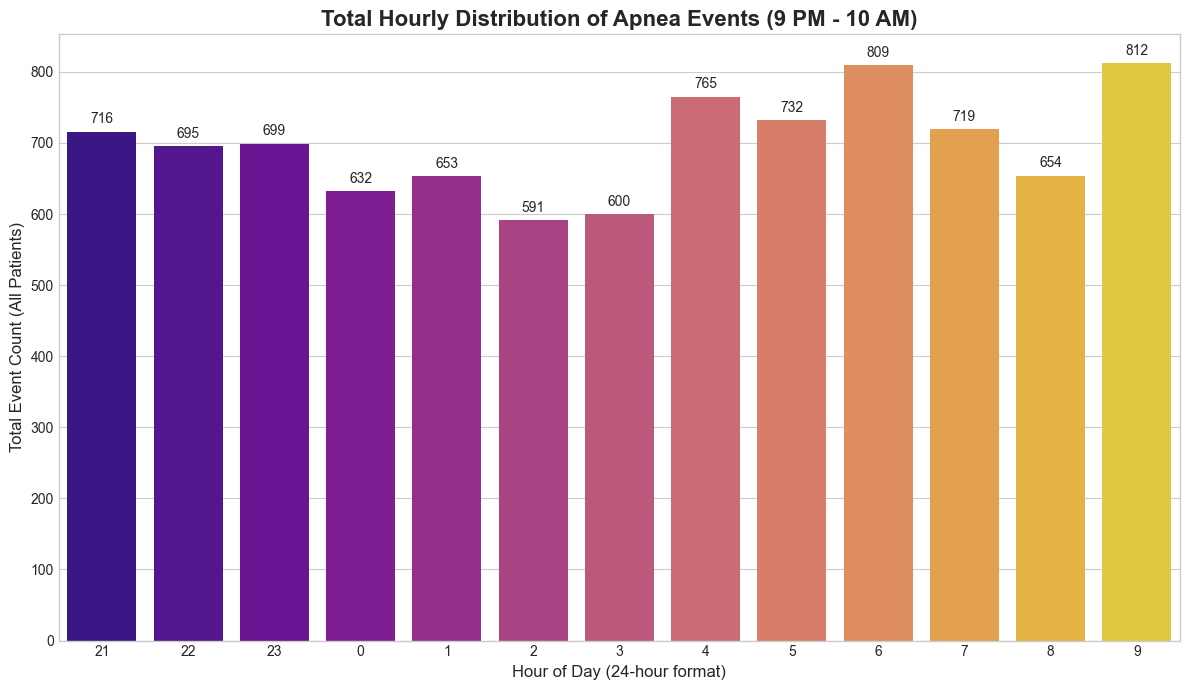

In [16]:
# plot_total_hourly_distribution.py

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_total_hourly_distribution(results_folder, output_filename="nightly_total_distribution.png"):
    """
    Aggregates all patient OSA events and plots their total hourly distribution
    as a simple bar chart.

    Args:
        results_folder (str): The path to the folder containing the _osa.csv files.
        output_filename (str): The filename for the saved plot image.
    """
    # --- 1. Find and aggregate all result files into a single DataFrame ---
    search_pattern = os.path.join(results_folder, "*_osa.csv")
    result_files = glob.glob(search_pattern)

    if not result_files:
        print(f"Error: No '*_osa.csv' files found in the folder: '{results_folder}'")
        return

    print(f"Found {len(result_files)} patient result files. Aggregating data...")

    all_events_df_list = []
    for file_path in result_files:
        try:
            df = pd.read_csv(file_path)
            if not df.empty:
                all_events_df_list.append(df)
        except pd.errors.EmptyDataError:
            continue
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")

    if not all_events_df_list:
        print("No events found across all patient files. Nothing to plot.")
        return

    combined_df = pd.concat(all_events_df_list, ignore_index=True)
    print(f"Total events from all patients: {len(combined_df)}")

    # --- 2. Prepare data for plotting total counts ---
    # Extract the hour from the timestamp
    combined_df['hour'] = pd.to_datetime(combined_df['time'], format='%H:%M:%S').dt.hour

    # <<< MODIFIED: Group only by 'hour' to get the total count across all patients
    hourly_counts = combined_df['hour'].value_counts()

    # --- 3. Order the hours correctly for the nightly window ---
    nightly_hours_order = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    # Re-index the counts to match our desired order and fill in 0 for any hours with no events
    hourly_counts_sorted = hourly_counts.reindex(nightly_hours_order, fill_value=0).reset_index()
    hourly_counts_sorted.columns = ['Hour', 'EventCount']

    # --- 4. Create and customize the plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))

    ax = sns.barplot(
        x='Hour',
        y='EventCount',
        data=hourly_counts_sorted,
        palette='plasma' # Use a different color palette
    )

    # Add the exact count on top of each bar
    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), '.0f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 9),
            textcoords='offset points'
        )

    plt.title('Total Hourly Distribution of Apnea Events (9 PM - 10 AM)', fontsize=16, fontweight='bold')
    plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
    plt.ylabel('Total Event Count (All Patients)', fontsize=12)
    plt.xticks(ticks=range(len(nightly_hours_order)), labels=nightly_hours_order)
    plt.tight_layout()

    # --- 5. Save and show the plot ---
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot successfully saved to '{output_filename}'")
    
    plt.show()

if __name__ == "__main__":
    RESULTS_FOLDER = './smile_osa_results'
    plot_total_hourly_distribution(results_folder=RESULTS_FOLDER)

Found 18 patient result files. Aggregating data...
Total events from all patients: 9077

Plot successfully saved to 'nightly_stacked_distribution.png'


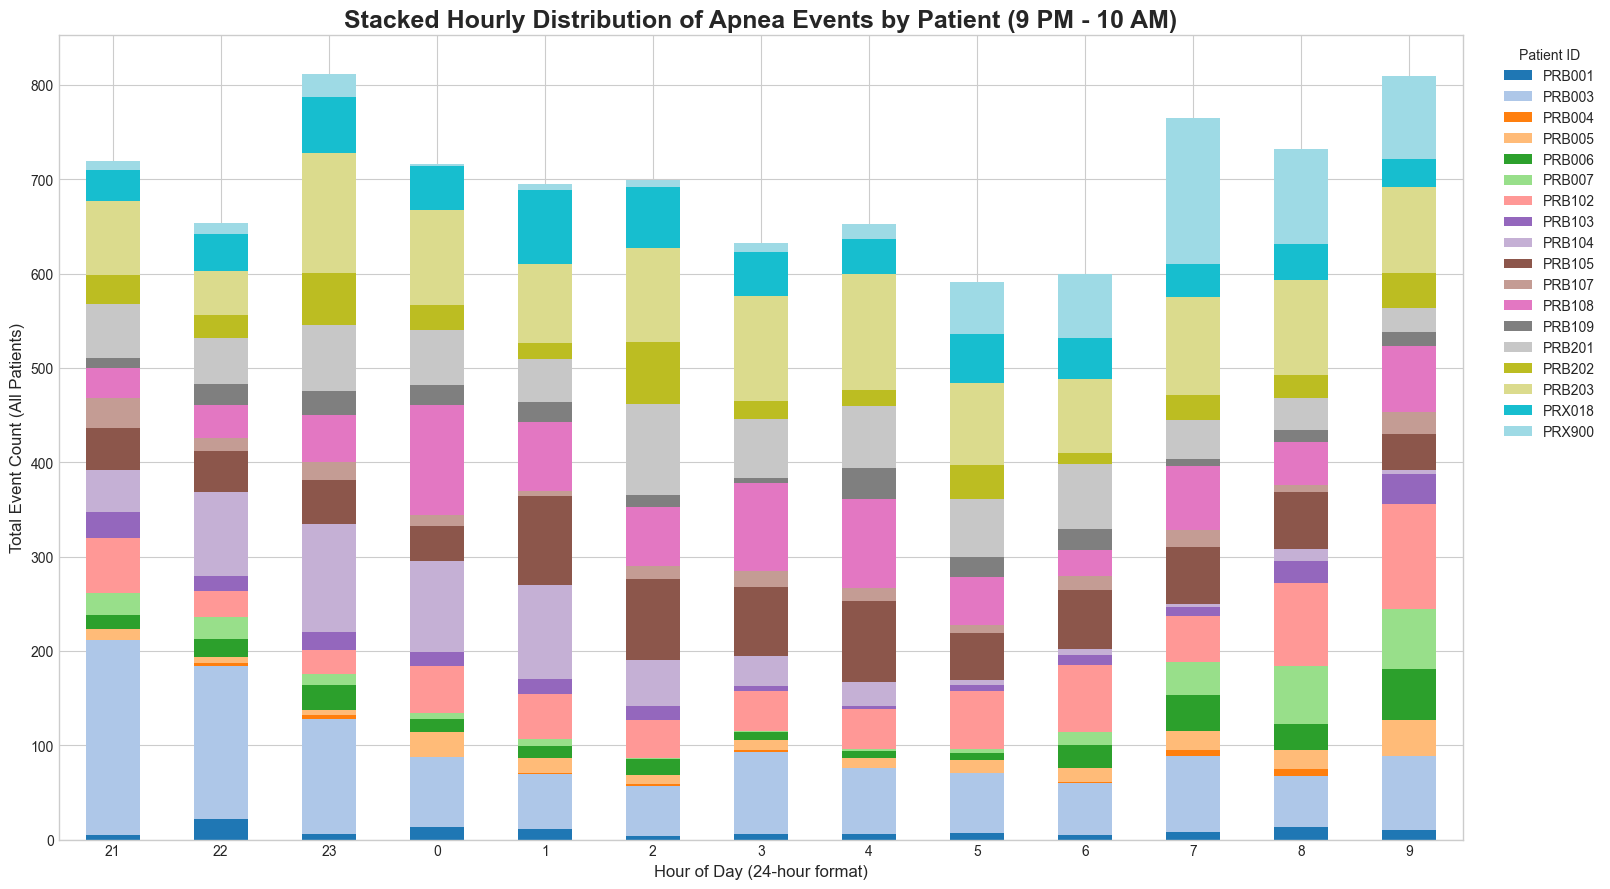

In [4]:
def plot_stacked_hourly_distribution(results_folder, output_filename="nightly_stacked_distribution.png"):
    """
    Aggregates all patient OSA events and plots their hourly distribution
    as a stacked bar chart, showing each patient's contribution.

    Args:
        results_folder (str): The path to the folder containing the _osa.csv files.
        output_filename (str): The filename for the saved plot image.
    """
    # --- 1. Find and aggregate all result files, adding a PatientID column ---
    search_pattern = os.path.join(results_folder, "*_osa.csv")
    result_files = glob.glob(search_pattern)

    if not result_files:
        print(f"Error: No '*_osa.csv' files found in the folder: '{results_folder}'")
        return

    print(f"Found {len(result_files)} patient result files. Aggregating data...")

    all_events_df_list = []
    for file_path in result_files:
        try:
            df = pd.read_csv(file_path)
            if not df.empty:
                # Extract patient prefix and add it as a new column
                filename = os.path.basename(file_path)
                patient_id = filename.split('_osa.csv')[0]
                df['PatientID'] = patient_id
                all_events_df_list.append(df)
        except pd.errors.EmptyDataError:
            continue
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")

    if not all_events_df_list:
        print("No events found across all patient files. Nothing to plot.")
        return

    combined_df = pd.concat(all_events_df_list, ignore_index=True)
    print(f"Total events from all patients: {len(combined_df)}")

    # --- 2. Prepare data for stacking ---
    # Extract the hour from the timestamp
    combined_df['hour'] = pd.to_datetime(combined_df['time'], format='%H:%M:%S').dt.hour

    # Group by both hour and patient to get counts for each patient within each hour
    hourly_patient_counts = combined_df.groupby(['hour', 'PatientID']).size().reset_index(name='EventCount')

    # Pivot the data to get a format suitable for a stacked bar chart:
    # Rows will be hours, columns will be patients, values will be the event counts.
    pivoted_df = hourly_patient_counts.pivot(index='hour', columns='PatientID', values='EventCount').fillna(0)

    # --- 3. Order the hours correctly for the nightly window ---
    nightly_hours_order = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    # Reindex the DataFrame to ensure all hours are present and in the correct order
    pivoted_df = pivoted_df.reindex(nightly_hours_order, fill_value=0)

    # --- 4. Create and customize the plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Use pandas' built-in plotting for easy stacking
    ax = pivoted_df.plot(
        kind='bar',
        stacked=True,
        figsize=(18, 9),
        # Use a colormap that provides many distinct colors
        colormap='tab20' 
    )

    plt.title('Stacked Hourly Distribution of Apnea Events by Patient (9 PM - 10 AM)', fontsize=18, fontweight='bold')
    plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
    plt.ylabel('Total Event Count (All Patients)', fontsize=12)
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=0)
    
    # Move the legend outside of the plot area to prevent it from covering the bars
    plt.legend(title='Patient ID', bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for the legend

    # --- 5. Save and show the plot ---
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot successfully saved to '{output_filename}'")
    
    plt.show()
plot_stacked_hourly_distribution(results_folder=RESULTS_FOLDER)

Found 18 patient result files. Aggregating and normalizing data...
Total events from all patients: 9077

Plot successfully saved to 'nightly_normalized_stacked.png'


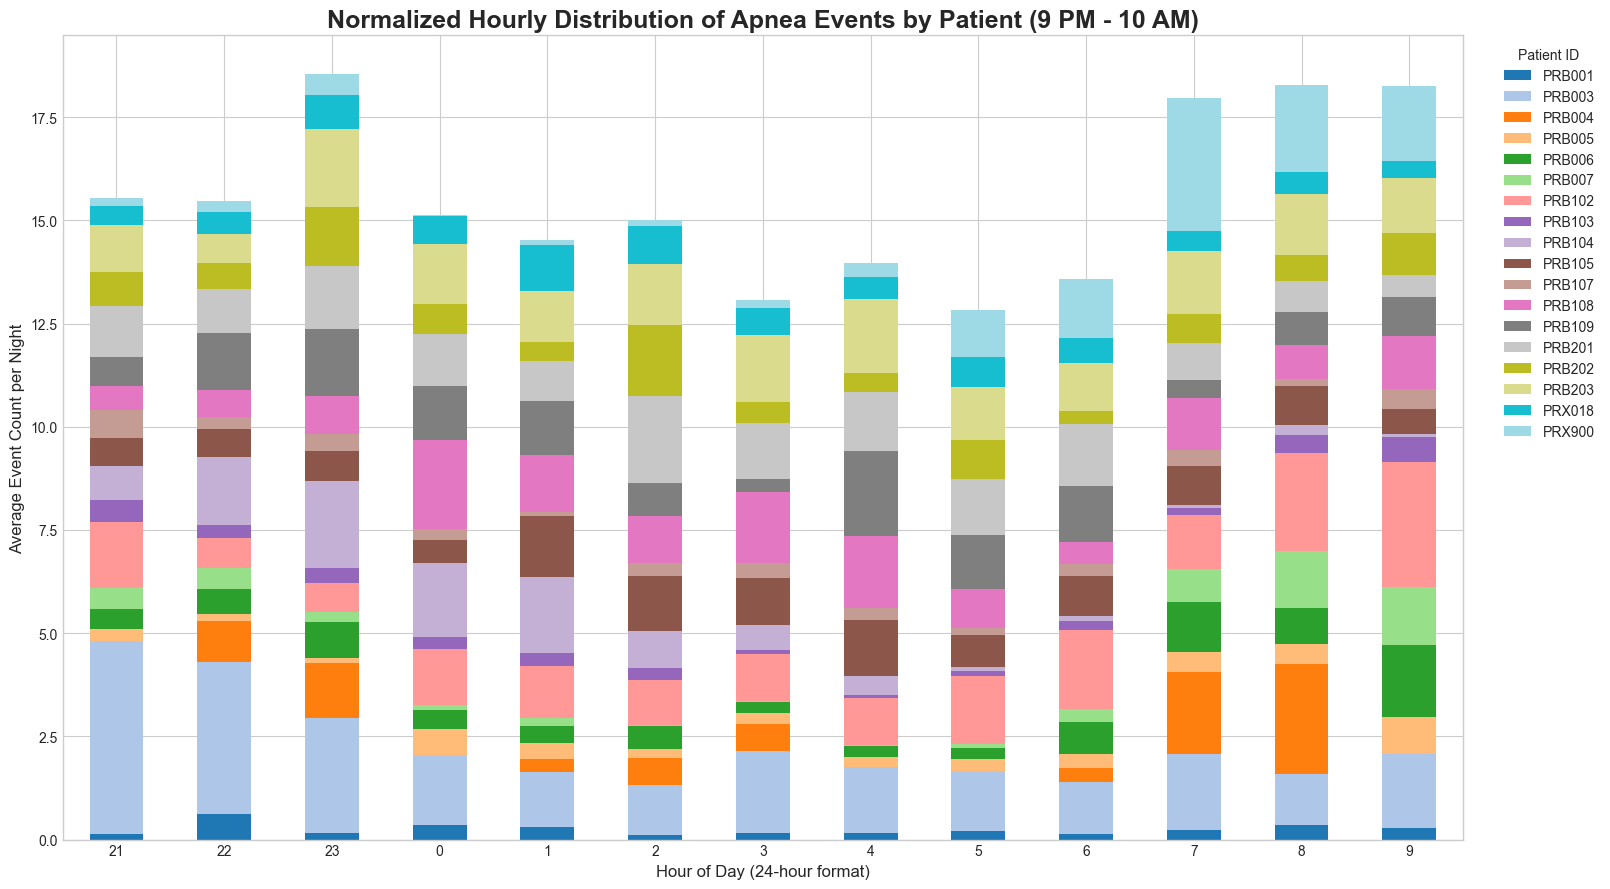

In [18]:
# plot_normalized_stacked_distribution.py

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_normalized_stacked_hourly_distribution(results_folder, output_filename="nightly_normalized_stacked.png"):
    """
    Aggregates all patient OSA events, normalizes them by the number of nights
    recorded per patient, and plots the result as a stacked bar chart.
    """
    search_pattern = os.path.join(results_folder, "*_osa.csv")
    result_files = glob.glob(search_pattern)

    if not result_files:
        print(f"Error: No '*_osa.csv' files found in the folder: '{results_folder}'")
        return

    print(f"Found {len(result_files)} patient result files. Aggregating and normalizing data...")

    all_events_df_list = []
    patient_night_counts = {} # Dictionary to store the number of unique nights per patient

    # --- 1. Find and aggregate all events, AND count nights per patient ---
    for file_path in result_files:
        try:
            df = pd.read_csv(file_path)
            filename = os.path.basename(file_path)
            patient_id = filename.split('_osa.csv')[0]

            if not df.empty:
                # Add PatientID column to the events DataFrame
                df['PatientID'] = patient_id
                all_events_df_list.append(df)
                
                # Count the number of unique nights for this patient and store it
                num_nights = df['date'].nunique()
                patient_night_counts[patient_id] = num_nights
            else:
                # If a patient has an empty OSA file, they have 0 nights with events
                patient_night_counts[patient_id] = 0

        except Exception as e:
            print(f"Could not process file {file_path}: {e}")

    if not all_events_df_list:
        print("No events found across all patient files. Nothing to plot.")
        return

    combined_df = pd.concat(all_events_df_list, ignore_index=True)
    print(f"Total events from all patients: {len(combined_df)}")

    # --- 2. Calculate TOTAL hourly event counts for each patient ---
    combined_df['hour'] = pd.to_datetime(combined_df['time'], format='%H:%M:%S').dt.hour
    hourly_patient_counts = combined_df.groupby(['hour', 'PatientID']).size().reset_index(name='TotalEventCount')

    # --- 3. Normalize the counts by the number of nights ---
    # Map the number of nights to each row in the counts DataFrame
    hourly_patient_counts['NumNights'] = hourly_patient_counts['PatientID'].map(patient_night_counts)
    
    # Calculate the normalized value: Average Events Per Night
    # Avoid division by zero for patients with 0 nights
    hourly_patient_counts['AvgEventsPerNight'] = hourly_patient_counts.apply(
        lambda row: row['TotalEventCount'] / row['NumNights'] if row['NumNights'] > 0 else 0,
        axis=1
    )

    # --- 4. Pivot the NORMALIZED data for plotting ---
    pivoted_df = hourly_patient_counts.pivot(index='hour', columns='PatientID', values='AvgEventsPerNight').fillna(0)
    
    # --- 5. Order the hours correctly for the nightly window ---
    nightly_hours_order = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    pivoted_df = pivoted_df.reindex(nightly_hours_order, fill_value=0)

    # --- 6. Create and customize the plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    
    ax = pivoted_df.plot(
        kind='bar',
        stacked=True,
        figsize=(18, 9),
        colormap='tab20' 
    )

    plt.title('Normalized Hourly Distribution of Apnea Events by Patient (9 PM - 10 AM)', fontsize=18, fontweight='bold')
    plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
    plt.ylabel('Average Event Count per Night', fontsize=12)
    
    plt.xticks(rotation=0)
    plt.legend(title='Patient ID', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # --- 7. Save and show the plot ---
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot successfully saved to '{output_filename}'")
    
    plt.show()

if __name__ == "__main__":
    RESULTS_FOLDER = 'smile_osa_results'
    plot_normalized_stacked_hourly_distribution(results_folder=RESULTS_FOLDER)


Processing patient: PRB005

Processing patient: PRB202

Processing patient: PRB107

Processing patient: PRB203

Processing patient: PRB004

Processing patient: PRX018

Processing patient: PRB201

Processing patient: PRB105

Processing patient: PRB006

Processing patient: PRB007

Processing patient: PRB104

Processing patient: PRB108

Processing patient: PRB109

Processing patient: PRB003

Processing patient: PRB001

Processing patient: PRB102

Processing patient: PRX900

Processing patient: PRB103

--- Generating Normalized Hourly Box Plot ---


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_56829/3242457892.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



Plot successfully saved to 'normalized_hourly_boxplot.png'


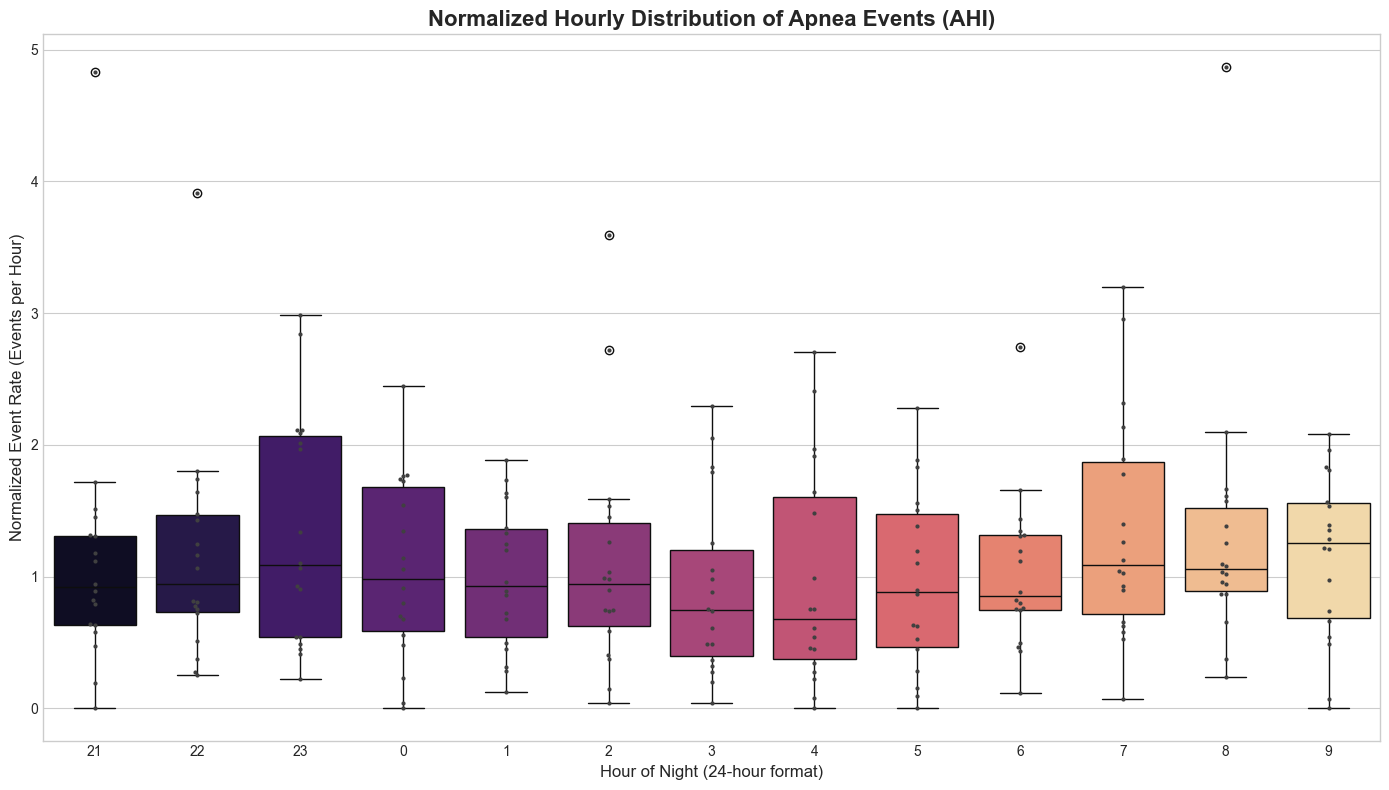

In [15]:
# plot_normalized_hourly_boxplot_fixed.py

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

def analyze_normalized_hourly_events(results_folder, data_root_folder, output_filename="normalized_hourly_boxplot.png"):
    """
    Calculates the normalized event rate (AHI) for each hour of the night for each patient
    and visualizes the distribution using a box plot.
    """
    SAMPLING_RATE_HZ = 12.5
    
    result_files = glob.glob(os.path.join(results_folder, "*_osa.csv"))
    if not result_files:
        print(f"Error: No result files found in '{results_folder}'.")
        return

    all_hourly_ahi_data = []
    scotland_tz = pytz.timezone('Europe/London')
    nightly_hours_order = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    for event_file_path in result_files:
        patient_id_prefix = os.path.basename(event_file_path).split('_osa.csv')[0]
        print(f"\nProcessing patient: {patient_id_prefix}")

        # --- Load Apnea Events ---
        try:
            event_df = pd.read_csv(event_file_path)
            event_df['datetime'] = pd.to_datetime(event_df['date'] + ' ' + event_df['time'])
            event_df['hour'] = event_df['datetime'].dt.hour
            apnea_counts_by_hour = event_df.groupby('hour').size()
        except Exception as e:
            print(f"  - Could not process apnea file {event_file_path}: {e}")
            continue

        # --- Load Raw Respeck Data ---
        search_pattern = os.path.join(data_root_folder, f"{patient_id_prefix}*/Respeck/*.csv")
        raw_files = glob.glob(search_pattern)
        if not raw_files:
            print(f"  - No raw data files found for {patient_id_prefix}. Skipping.")
            continue
        
        # <<< FIX: Added on_bad_lines='skip' to handle corrupted rows in the CSV
        try:
            raw_df_list = [pd.read_csv(file, on_bad_lines='skip') for file in raw_files]
            # Filter out any empty DataFrames that might result from a totally bad file
            raw_df_list = [df for df in raw_df_list if not df.empty]
            if not raw_df_list:
                print(f"  - All raw data files for {patient_id_prefix} were empty or could not be parsed. Skipping.")
                continue
            raw_df = pd.concat(raw_df_list, ignore_index=True)
        except Exception as e:
            print(f"  - A critical error occurred while reading raw files for {patient_id_prefix}: {e}")
            continue

        # --- Calculate Hourly AHI for this patient ---
        raw_df['datetime'] = pd.to_datetime(raw_df['interpolatedPhoneTimestamp'], unit='ms', utc=True).dt.tz_convert(scotland_tz)
        raw_df['hour'] = raw_df['datetime'].dt.hour
        total_samples_by_hour = raw_df.groupby('hour').size()

        for hour in nightly_hours_order:
            num_events = apnea_counts_by_hour.get(hour, 0)
            num_samples = total_samples_by_hour.get(hour, 0)

            if num_samples > 0:
                recording_time_hours = num_samples / SAMPLING_RATE_HZ / 3600
                hourly_ahi = num_events / recording_time_hours if recording_time_hours > 0 else 0
                all_hourly_ahi_data.append({
                    'PatientID': patient_id_prefix,
                    'Hour': hour,
                    'HourlyAHI': hourly_ahi
                })

    # --- Create a final master DataFrame ---
    if not all_hourly_ahi_data:
        print("No valid hourly data could be calculated. Aborting.")
        return

    final_df = pd.DataFrame(all_hourly_ahi_data)
    
    print("\n--- Generating Normalized Hourly Box Plot ---")

    # --- Create and customize the plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 8))
    
    ax = sns.boxplot(
        x='Hour',
        y='HourlyAHI',
        data=final_df,
        order=nightly_hours_order,
        palette='magma'
    )
    
    sns.swarmplot(x='Hour', y='HourlyAHI', data=final_df, order=nightly_hours_order, color=".25", size=3, ax=ax)

    plt.title('Normalized Hourly Distribution of Apnea Events (AHI)', fontsize=16, fontweight='bold')
    plt.xlabel('Hour of Night (24-hour format)', fontsize=12)
    plt.ylabel('Normalized Event Rate (Events per Hour)', fontsize=12)
    plt.tight_layout()

    # --- Save and show the plot ---
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot successfully saved to '{output_filename}'")
    plt.show()

if __name__ == "__main__":
    RESULTS_FOLDER = "./smile_osa_results"
    DATA_ROOT_FOLDER = "../data/Smile"
    OUTPUT_FILENAME = "normalized_hourly_boxplot.png"
    
    analyze_normalized_hourly_events(RESULTS_FOLDER, DATA_ROOT_FOLDER, output_filename=OUTPUT_FILENAME)

In [5]:

def load_and_combine_raw_data(patient_id_prefix, data_root_folder):
    """
    Finds the patient's data folder using a prefix, loads all CSVs from the 
    'Respeck' subfolder, and concatenates them into a single, sorted DataFrame.
    """
    search_pattern = os.path.join(data_root_folder, f"{patient_id_prefix}*")
    matching_folders = glob.glob(search_pattern)
    
    if not matching_folders:
        print(f"  - ERROR: No data folder found starting with '{patient_id_prefix}'")
        return None
    
    patient_folder = matching_folders[0]
    respeck_folder = os.path.join(patient_folder, 'Respeck')

    if not os.path.isdir(respeck_folder):
        print(f"  - ERROR: No 'Respeck' subfolder found in '{patient_folder}'")
        return None

    csv_files = glob.glob(os.path.join(respeck_folder, '*.csv'))
    
    if not csv_files:
        print(f"  - ERROR: No CSV files found in '{respeck_folder}'")
        return None
        
    print(f"  - Found {len(csv_files)} raw data files for patient {patient_id_prefix}. Loading...")

    df_list = [pd.read_csv(file) for file in csv_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df.sort_values(by='interpolatedPhoneTimestamp', inplace=True)
    
    return combined_df

def plot_event_waveforms_for_patient(patient_id_prefix, event_df, raw_df):
    """
    Processes the loaded data and generates plots for each event.
    """
    output_dir = f"{patient_id_prefix}_event_plots"
    os.makedirs(output_dir, exist_ok=True)
    print(f"  - Plots will be saved to the '{output_dir}' directory.")

    raw_df['datetime'] = pd.to_datetime(raw_df['interpolatedPhoneTimestamp'], unit='ms', utc=True)
    scotland_tz = pytz.timezone('Europe/London')
    raw_df['datetime'] = raw_df['datetime'].dt.tz_convert(scotland_tz)
    raw_df.set_index('datetime', inplace=True)

    for index, event_row in event_df.iterrows():
        event_time_str = f"{event_row['date']} {event_row['time']}"
        event_time = pd.to_datetime(event_time_str).tz_localize(scotland_tz)

        start_window = event_time - pd.Timedelta(minutes=1)
        end_window = event_time + pd.Timedelta(minutes=1)

        data_segment = raw_df.loc[start_window:end_window]

        if data_segment.empty:
            print(f"    - WARNING: No raw data found for event at {event_time_str}. Skipping plot.")
            continue

        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(15, 6))
        plt.plot(data_segment.index, data_segment['breathingSignal'], label='Breathing Signal', color='royalblue')
        plt.axvline(x=event_time, color='red', linestyle='--', linewidth=2, label=f'Apnea Event Detected\n({event_time.strftime("%H:%M:%S")})')
        plt.title(f"Patient {patient_id_prefix} - Breathing Signal Around Event {index + 1}", fontsize=16, fontweight='bold')
        plt.xlabel("Time (Scotland Time)", fontsize=12)
        plt.ylabel("Breathing Signal Amplitude", fontsize=12)
        plt.legend()
        plt.tight_layout()

        plot_filename = os.path.join(output_dir, f"event_{index + 1}_{event_time.strftime('%Y%m%d_%H%M%S')}.png")
        plt.savefig(plot_filename, dpi=150)
        plt.close()

    print(f"  - Finished plotting. {len(event_df)} plots have been saved.")


def main():
    # --- Configuration ---
    RESULTS_FOLDER = "smile_osa_results"
    DATA_ROOT_FOLDER = "../data/Smile"

    # <<< MODIFIED: Specify the single patient prefix to plot
    patient_id_prefix = "PRB001" 
    
    # --- Construct the path to the specific event file ---
    event_file_path = os.path.join(RESULTS_FOLDER, f"{patient_id_prefix}_osa.csv")

    print(f"\n--- Processing a single patient: {patient_id_prefix} ---")

    # --- 1. Load the detected event times ---
    try:
        event_df = pd.read_csv(event_file_path)
        if event_df.empty:
            print("  - No events in result file. Nothing to plot.")
            return
        print(f"  - Found {len(event_df)} events in {os.path.basename(event_file_path)}.")
    except Exception as e:
        print(f"  - ERROR: Could not read event file {event_file_path}: {e}")
        return

    # --- 2. Load the corresponding raw sensor data ---
    raw_df = load_and_combine_raw_data(patient_id_prefix, DATA_ROOT_FOLDER)
    
    if raw_df is None or raw_df.empty:
        print(f"  - Could not load raw data for {patient_id_prefix}. Aborting.")
        return

    # --- 3. Generate plots for this patient ---
    plot_event_waveforms_for_patient(patient_id_prefix, event_df, raw_df)

if __name__ == "__main__":
    main()


--- Processing a single patient: PRB001 ---
  - Found 116 events in PRB001_osa.csv.
  - Found 60 raw data files for patient PRB001. Loading...
  - Plots will be saved to the 'PRB001_event_plots' directory.
  - Finished plotting. 116 plots have been saved.



Processing patient: PRB005

Processing patient: PRB202

Processing patient: PRB107

Processing patient: PRB203

Processing patient: PRB004

Processing patient: PRX018

Processing patient: PRB201

Processing patient: PRB105

Processing patient: PRB006

Processing patient: PRB007

Processing patient: PRB104

Processing patient: PRB108

Processing patient: PRB109

Processing patient: PRB003

Processing patient: PRB001
  - No diary file found for PRB001. Skipping.

Processing patient: PRB102

Processing patient: PRX900

Processing patient: PRB103

      FINAL MERGED DATA VERIFICATION
Total matched nights found: 366
Data from 16 unique patients was merged: ['PRB202', 'PRB107', 'PRB203', 'PRB004', 'PRX018', 'PRB201', 'PRB105', 'PRB006', 'PRB007', 'PRB104', 'PRB108', 'PRB109', 'PRB003', 'PRB102', 'PRX900', 'PRB103']

Overall distribution of Diary Scores (answer7):
DiaryScore
0     51
1     64
2     90
3    106
4     18
5     37

Showing first 5 rows of the merged table:
    SleepDate  EventC

/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_56829/1228095271.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DiaryScore', y='EventCount', data=final_df, palette='plasma')


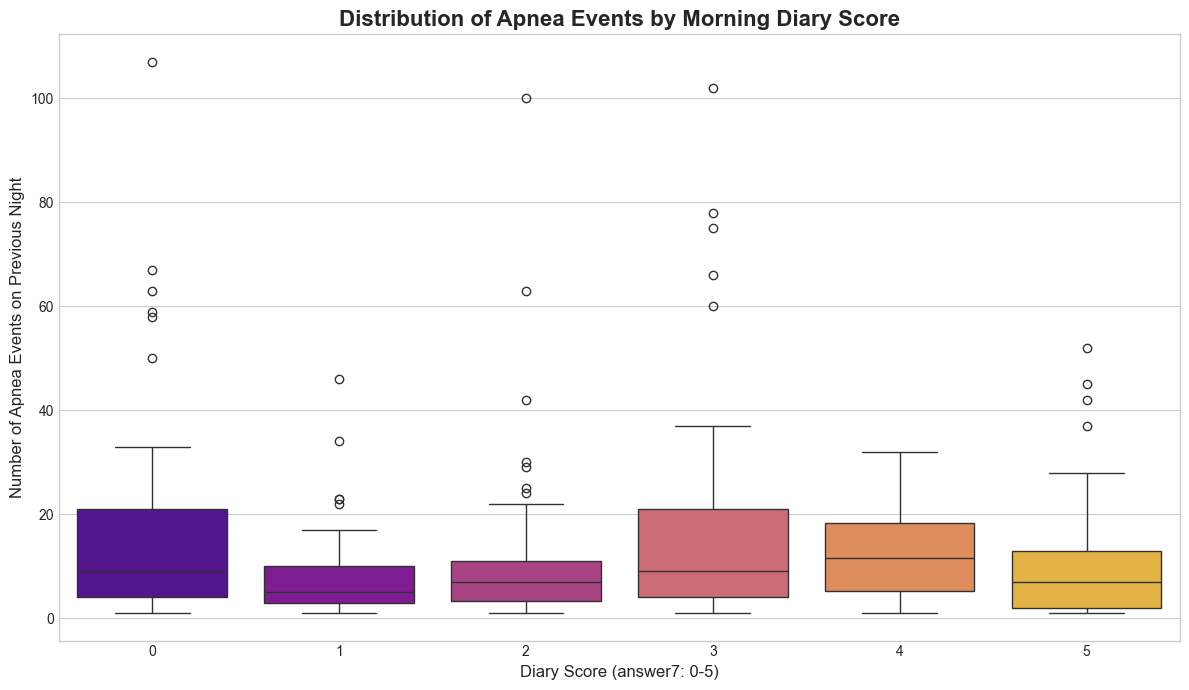

Saved final scatter plot to 'scatterplot_diary_vs_events_final.png'


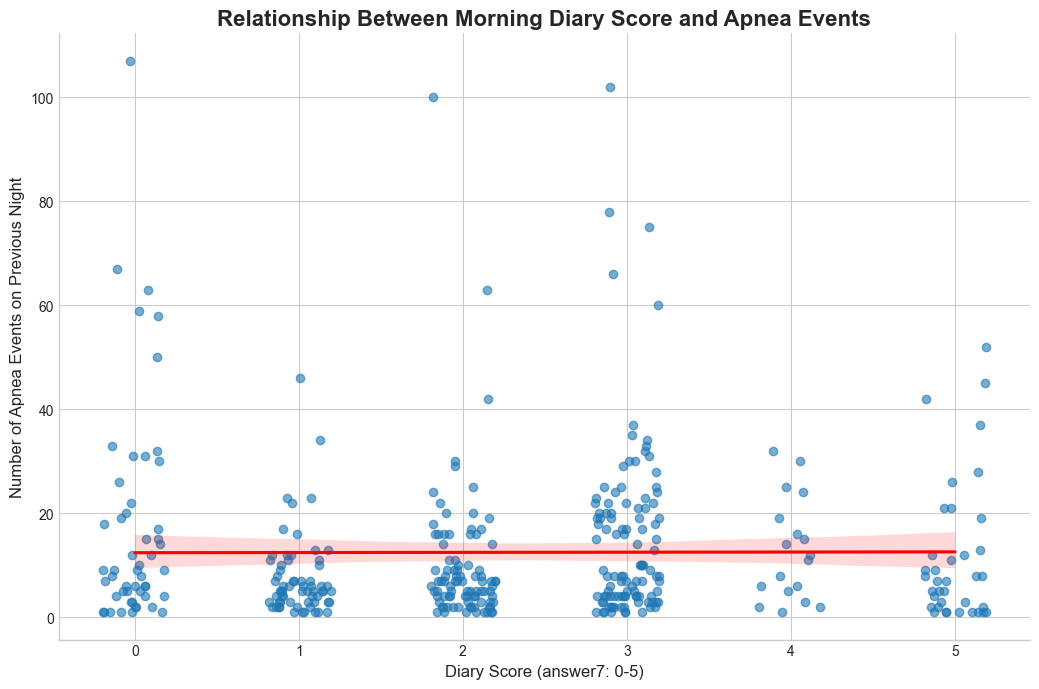

In [12]:
# plot_diary_correlation_final_with_verification.py

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

# ... (The analyze_diary_vs_events function remains exactly the same as before) ...
def analyze_diary_vs_events(results_folder, data_root_folder):
    """
    Loads diary scores and apnea event counts, correctly aligning the diary score
    with the previous night's events using a 'Sleep Date' logic.
    """
    result_files = glob.glob(os.path.join(results_folder, "*_osa.csv"))
    if not result_files:
        print(f"Error: No result files found in '{results_folder}'.")
        return

    all_daily_data = []
    scotland_tz = pytz.timezone('Europe/London')
    
    for event_file_path in result_files:
        patient_id_prefix = os.path.basename(event_file_path).split('_osa.csv')[0]
        print(f"\nProcessing patient: {patient_id_prefix}")

        try:
            event_df = pd.read_csv(event_file_path)
            if event_df.empty:
                apnea_counts_per_day = pd.DataFrame(columns=['SleepDate', 'EventCount'])
            else:
                event_df['datetime'] = pd.to_datetime(event_df['date'] + ' ' + event_df['time'])
                event_df['SleepDate'] = event_df['datetime'].apply(
                    lambda dt: (dt + pd.Timedelta(days=1)).strftime('%Y-%m-%d') if dt.hour >= 21 else dt.strftime('%Y-%m-%d')
                )
                apnea_counts_per_day = event_df.groupby('SleepDate').size().reset_index(name='EventCount')
        except Exception as e:
            print(f"  - Could not process apnea file {event_file_path}: {e}")
            continue

        diary_search = glob.glob(os.path.join(data_root_folder, f"{patient_id_prefix}*/Diary/*.csv"))
        if not diary_search:
            print(f"  - No diary file found for {patient_id_prefix}. Skipping.")
            continue
        diary_file_path = diary_search[0]

        try:
            diary_df = pd.read_csv(diary_file_path)
            diary_df['datetime'] = pd.to_datetime(diary_df['timestamp'], unit='s', utc=True).dt.tz_convert(scotland_tz)
            diary_df['SleepDate'] = diary_df['datetime'].dt.strftime('%Y-%m-%d')
            diary_scores_per_day = diary_df[['SleepDate', 'answer7']].rename(columns={'answer7': 'DiaryScore'})
            diary_scores_per_day = diary_scores_per_day.drop_duplicates(subset='SleepDate', keep='last')
        except Exception as e:
            print(f"  - Could not process diary file {diary_file_path}: {e}")
            continue

        daily_summary = pd.merge(apnea_counts_per_day, diary_scores_per_day, on='SleepDate', how='inner')
        daily_summary['PatientID'] = patient_id_prefix
        all_daily_data.append(daily_summary)

    if not all_daily_data:
        print("No matching data found between apnea events and diary entries. Aborting.")
        return

    final_df = pd.concat(all_daily_data, ignore_index=True)
    final_df['EventCount'] = final_df['EventCount'].astype(int)
    final_df['DiaryScore'] = final_df['DiaryScore'].astype(int)

    # --- UPDATED VERIFICATION SECTION ---
    print("\n" + "="*50)
    print("      FINAL MERGED DATA VERIFICATION")
    print("="*50)
    print(f"Total matched nights found: {len(final_df)}")
    
    unique_patients = final_df['PatientID'].unique()
    print(f"Data from {len(unique_patients)} unique patients was merged: {list(unique_patients)}")
    
    # <<< NEW: Calculate and print the diary score distribution
    diary_score_counts = final_df['DiaryScore'].value_counts().sort_index()
    print("\nOverall distribution of Diary Scores (answer7):")
    print(diary_score_counts.to_string())
    
    print("\nShowing first 5 rows of the merged table:")
    print(final_df.head())
    
    print("\nShowing last 5 rows of the merged table:")
    print(final_df.tail())
    print("="*50 + "\n")

    # --- PLOTTING SECTION (remains the same) ---
    print("--- Generating Plots ---")
    
    # PLOT 1: Box Plot
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='DiaryScore', y='EventCount', data=final_df, palette='plasma')
    plt.title('Distribution of Apnea Events by Morning Diary Score', fontsize=16, fontweight='bold')
    plt.xlabel('Diary Score (answer7: 0-5)', fontsize=12)
    plt.ylabel('Number of Apnea Events on Previous Night', fontsize=12)
    plt.tight_layout()
    plt.savefig("boxplot_diary_vs_events_final.png", dpi=300)
    print("\nSaved final box plot to 'boxplot_diary_vs_events_final.png'")
    plt.show()

    # PLOT 2: Scatter Plot
    sns.lmplot(
        x='DiaryScore',
        y='EventCount',
        data=final_df,
        x_jitter=.2,
        height=7,
        aspect=1.5,
        scatter_kws={'alpha':0.6},
        line_kws={'color': 'red'}
    )
    plt.title('Relationship Between Morning Diary Score and Apnea Events', fontsize=16, fontweight='bold')
    plt.xlabel('Diary Score (answer7: 0-5)', fontsize=12)
    plt.ylabel('Number of Apnea Events on Previous Night', fontsize=12)
    plt.tight_layout()
    plt.savefig("scatterplot_diary_vs_events_final.png", dpi=300)
    print("Saved final scatter plot to 'scatterplot_diary_vs_events_final.png'")
    plt.show()

if __name__ == "__main__":
    RESULTS_FOLDER = "./smile_osa_results"
    DATA_ROOT_FOLDER = "../data/Smile"
    analyze_diary_vs_events(RESULTS_FOLDER, DATA_ROOT_FOLDER)


--- Processing a single patient: PRB001 ---
  - Found 116 events in PRB001_osa.csv.
  - Found 60 raw data files for patient PRB001. Loading...
  - Plots will be saved to the 'PRB001_event_plots' directory.
  - Finished plotting. 116 plots have been saved.



Processing patient: PRB005

Processing patient: PRB202

Processing patient: PRB107

Processing patient: PRB203

Processing patient: PRB004

Processing patient: PRX018

Processing patient: PRB201

Processing patient: PRB105

Processing patient: PRB006

Processing patient: PRB007

Processing patient: PRB104

Processing patient: PRB108

Processing patient: PRB109

Processing patient: PRB003

Processing patient: PRB001

Processing patient: PRB102

Processing patient: PRX900

Processing patient: PRB103

      FINAL MERGED & NORMALIZED DATA VERIFICATION
  PatientID   SleepDate  EventCount  RecordingTimeHours  EventsPerHour  \
0    PRB202  2022-05-18           1            7.634133       0.130991   
1    PRB202  2022-05-19          31           17.074044       1.815621   
2    PRB202  2022-05-20           9           20.024311       0.449454   
3    PRB202  2022-05-22           7           10.958156       0.638794   
4    PRB202  2022-05-23           9           17.638067       0.510260   



/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_56829/180357343.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DiaryScore', y='EventsPerHour', data=final_df, palette='plasma')



Saved normalized box plot to 'boxplot_diary_vs_normalized_events.png'


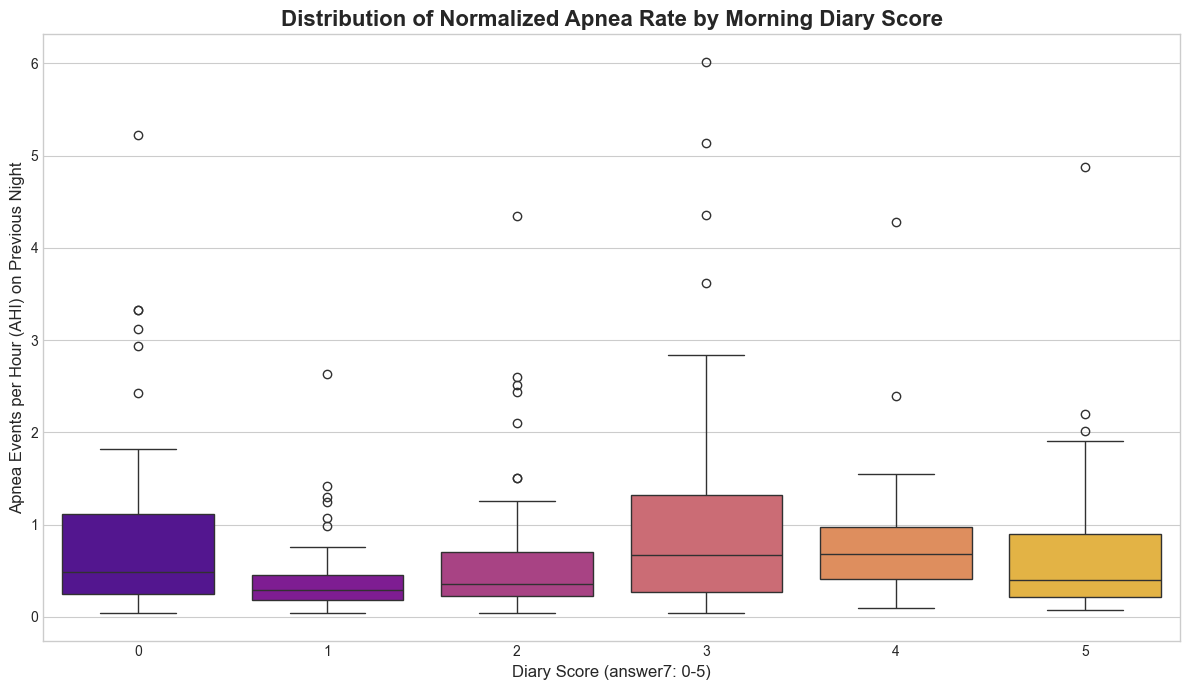

Saved normalized scatter plot to 'scatterplot_diary_vs_normalized_events.png'


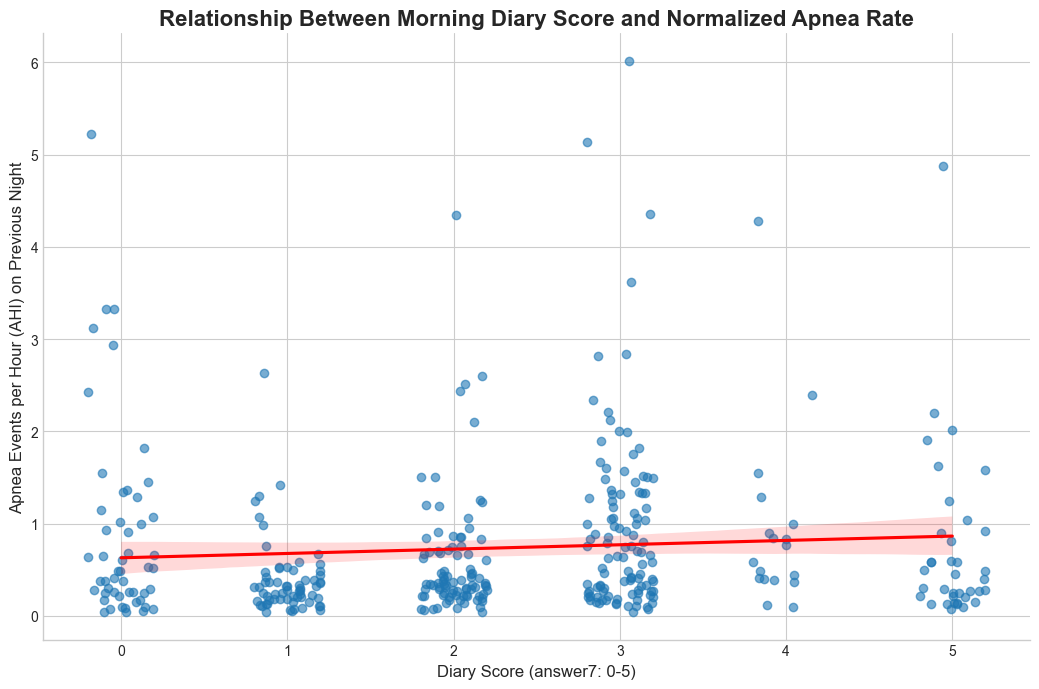

In [27]:
# plot_normalized_diary_correlation_fixed_concat.py

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

def analyze_normalized_diary_vs_events(results_folder, data_root_folder):
    """
    Calculates the normalized event rate (AHI) for each night, aligns it with the
    next-morning diary score, and creates visualizations of their relationship.
    """
    SAMPLING_RATE_HZ = 12.5
    
    result_files = glob.glob(os.path.join(results_folder, "*_osa.csv"))
    if not result_files:
        print(f"Error: No result files found in '{results_folder}'.")
        return

    all_daily_data = []
    scotland_tz = pytz.timezone('Europe/London')

    for event_file_path in result_files:
        patient_id_prefix = os.path.basename(event_file_path).split('_osa.csv')[0]
        print(f"\nProcessing patient: {patient_id_prefix}")

        try:
            event_df = pd.read_csv(event_file_path)
            event_df['datetime'] = pd.to_datetime(event_df['date'] + ' ' + event_df['time'])
            event_df['SleepDate'] = event_df['datetime'].apply(
                lambda dt: (dt + pd.Timedelta(days=1)).strftime('%Y-%m-%d') if dt.hour >= 21 else dt.strftime('%Y-%m-%d')
            )
            apnea_counts_per_night = event_df.groupby('SleepDate').size().reset_index(name='EventCount')
        except Exception as e:
            print(f"  - Could not process apnea file {event_file_path}: {e}")
            continue

        raw_search_pattern = os.path.join(data_root_folder, f"{patient_id_prefix}*/Respeck/*.csv")
        raw_files = glob.glob(raw_search_pattern)
        if not raw_files: continue
        
        try:
            raw_df_list = [pd.read_csv(file, on_bad_lines='skip') for file in raw_files]
            raw_df_list = [df for df in raw_df_list if not df.empty]
            if not raw_df_list: continue
            raw_df = pd.concat(raw_df_list, ignore_index=True)
        except Exception as e:
            print(f"  - A critical error occurred while reading raw files for {patient_id_prefix}: {e}")
            continue
        
        def get_sleep_date(dt):
            if pd.isna(dt):
                return None
            if dt.hour >= 21:
                return (dt + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
            else:
                return dt.strftime('%Y-%m-%d')

        raw_df['datetime'] = pd.to_datetime(raw_df['interpolatedPhoneTimestamp'], unit='ms', utc=True, errors='coerce').dt.tz_convert(scotland_tz)
        raw_df['SleepDate'] = raw_df['datetime'].apply(get_sleep_date)
        raw_df.dropna(subset=['SleepDate'], inplace=True)
        total_samples_per_night = raw_df.groupby('SleepDate').size().reset_index(name='SampleCount')

        nightly_summary = pd.merge(apnea_counts_per_night, total_samples_per_night, on='SleepDate', how='left')
        nightly_summary['RecordingTimeHours'] = nightly_summary['SampleCount'] / SAMPLING_RATE_HZ / 3600
        nightly_summary['EventsPerHour'] = nightly_summary.apply(
            lambda row: row['EventCount'] / row['RecordingTimeHours'] if row['RecordingTimeHours'] > 0 else 0,
            axis=1
        )
        
        diary_search = glob.glob(os.path.join(data_root_folder, f"{patient_id_prefix}*/Diary/*.csv"))
        if not diary_search: continue
        diary_file_path = diary_search[0]
        
        diary_df = pd.read_csv(diary_file_path)
        diary_df['datetime'] = pd.to_datetime(diary_df['timestamp'], unit='s', utc=True).dt.tz_convert(scotland_tz)
        diary_df['SleepDate'] = diary_df['datetime'].dt.strftime('%Y-%m-%d')
        diary_scores_per_day = diary_df[['SleepDate', 'answer7']].rename(columns={'answer7': 'DiaryScore'})
        diary_scores_per_day = diary_scores_per_day.drop_duplicates(subset='SleepDate', keep='last')

        final_summary = pd.merge(nightly_summary, diary_scores_per_day, on='SleepDate', how='inner')
        final_summary['PatientID'] = patient_id_prefix
        all_daily_data.append(final_summary)

    if not all_daily_data:
        print("No matching data found. Aborting.")
        return

    # <<< FIX: Use pd.concat to combine a list of DataFrames
    final_df = pd.concat(all_daily_data, ignore_index=True)
    
    final_df['DiaryScore'] = final_df['DiaryScore'].astype(int)

    print("\n" + "="*50)
    print("      FINAL MERGED & NORMALIZED DATA VERIFICATION")
    print("="*50)
    print(final_df[['PatientID', 'SleepDate', 'EventCount', 'RecordingTimeHours', 'EventsPerHour', 'DiaryScore']].head())
    print("="*50 + "\n")

    # --- PLOTTING ---
    print("--- Generating Plots ---")
    
    # ... (Plotting code remains the same) ...
    # PLOT 1: Box Plot
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='DiaryScore', y='EventsPerHour', data=final_df, palette='plasma')
    plt.title('Distribution of Normalized Apnea Rate by Morning Diary Score', fontsize=16, fontweight='bold')
    plt.xlabel('Diary Score (answer7: 0-5)', fontsize=12)
    plt.ylabel('Apnea Events per Hour (AHI) on Previous Night', fontsize=12)
    plt.tight_layout()
    plt.savefig("boxplot_diary_vs_normalized_events.png", dpi=300)
    print("\nSaved normalized box plot to 'boxplot_diary_vs_normalized_events.png'")
    plt.show()

    # PLOT 2: Scatter Plot
    sns.lmplot(
        x='DiaryScore',
        y='EventsPerHour',
        data=final_df,
        x_jitter=.2,
        height=7,
        aspect=1.5,
        scatter_kws={'alpha':0.6},
        line_kws={'color': 'red'}
    )
    plt.title('Relationship Between Morning Diary Score and Normalized Apnea Rate', fontsize=16, fontweight='bold')
    plt.xlabel('Diary Score (answer7: 0-5)', fontsize=12)
    plt.ylabel('Apnea Events per Hour (AHI) on Previous Night', fontsize=12)
    plt.tight_layout()
    plt.savefig("scatterplot_diary_vs_normalized_events.png", dpi=300)
    print("Saved normalized scatter plot to 'scatterplot_diary_vs_normalized_events.png'")
    plt.show()


if __name__ == "__main__":
    RESULTS_FOLDER = "./smile_osa_results"
    DATA_ROOT_FOLDER = "../data/Smile"
    analyze_normalized_diary_vs_events(RESULTS_FOLDER, DATA_ROOT_FOLDER)